Part 1: Understanding the Vision Transformer Architecture for 3D Data
First, let's understand the key components of a Vision Transformer (ViT) adapted for 3D microscopy data:

Patch Embedding: Converting 3D volumes into patches
Positional Encoding: Adding spatial information to the patches
Transformer Blocks: Self-attention mechanisms to process the data
Reconstruction: Converting processed features back to 3D volumes

Let's implement the first component - the 3D Patch Embedding - which is the foundation of our architecture:|

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PatchEmbed3D(nn.Module):
    """Convert 3D volume into patches and embed them.
    
    This class divides a 3D volume into non-overlapping patches and projects each patch
    into a higher-dimensional embedding space using a 3D convolutional layer.
    """
    def __init__(self, vol_size=(64, 64, 64), patch_size=(8, 8, 8), in_channels=1, embed_dim=768):
        """
        Initialize the 3D patch embedding layer.
        
        Args:
            vol_size (tuple): Size of the input volume (Depth, Height, Width)
            patch_size (tuple): Size of each patch (Depth, Height, Width)
            in_channels (int): Number of input channels (e.g., 1 for grayscale)
            embed_dim (int): Dimension of the embedding space for each patch
        """
        super().__init__()
        # Store the input parameters as attributes for later use
        self.vol_size = vol_size  # Size of the input volume
        self.patch_size = patch_size  # Size of each 3D patch
        
        # Calculate the total number of patches
        # For each dimension, we divide the volume size by the patch size
        # Then multiply these values to get the total number of patches
        # Integer division (//) ensures we get whole patches
        self.num_patches = (vol_size[0] // patch_size[0]) * \
                          (vol_size[1] // patch_size[1]) * \
                          (vol_size[2] // patch_size[2])
        
        # Create a 3D convolutional layer that will:
        # 1. Divide the volume into patches using kernel_size=patch_size
        # 2. Project each patch to embed_dim dimensions
        # 3. The stride=patch_size ensures non-overlapping patches
        self.proj = nn.Conv3d(
            in_channels,  # Number of input channels
            embed_dim,    # Embedding dimension for each patch
            kernel_size=patch_size,  # Size of each patch
            stride=patch_size         # Non-overlapping patches
        )
            
    def forward(self, x):
        """
        Forward pass of the patch embedding layer.
        
        Args:
            x (torch.Tensor): Input tensor of shape [B, C, D, H, W]
                B = batch size, C = channels, D = depth, H = height, W = width
        
        Returns:
            torch.Tensor: Embedded patches of shape [B, num_patches, embed_dim]
        """
        # Store the original shape for reference
        B, C, D, H, W = x.shape
        
        # Apply the 3D convolution to extract and project patches
        # This changes the shape to [B, embed_dim, D', H', W']
        # where D', H', W' are reduced dimensions (D/patch_D, H/patch_H, W/patch_W)
        x = self.proj(x)
        
        # Now we need to reshape the tensor for the transformer
        # 1. flatten(2): Flattens all dimensions from index 2 onwards
        #    Changes shape from [B, embed_dim, D', H', W'] to [B, embed_dim, D'*H'*W']
        # 2. transpose(1, 2): Swaps dimensions 1 and 2
        #    Changes shape from [B, embed_dim, D'*H'*W'] to [B, D'*H'*W', embed_dim]
        #    This is equivalent to [B, num_patches, embed_dim]
        x = x.flatten(2).transpose(1, 2)
        
        return x

Original volume shape: torch.Size([1, 1, 64, 64, 64])
Number of patches expected: 512
Embedded patches shape: torch.Size([1, 512, 128])
Patch embedding test passed!


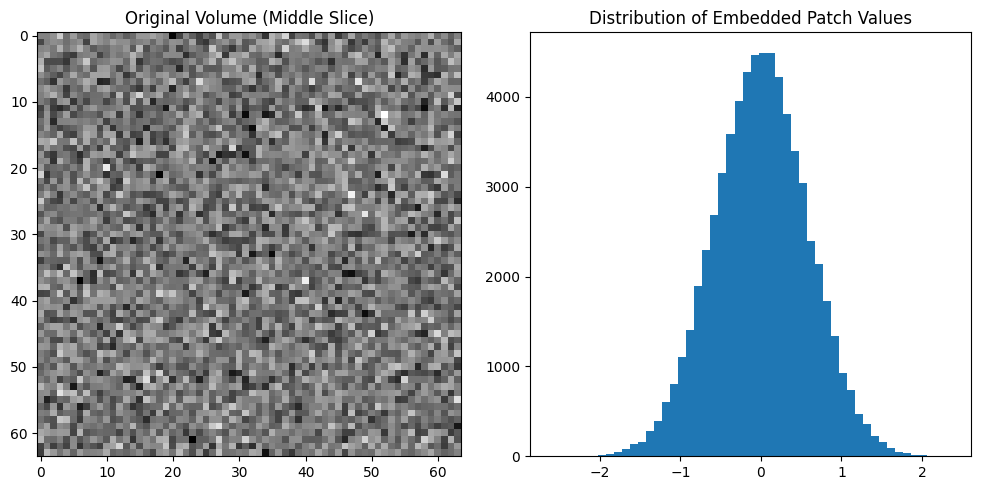

In [10]:
def test_patch_embedding():
    """
    Test function to demonstrate and visualize the 3D patch embedding process.
    
    This function:
    1. Creates a random 3D volume
    2. Applies the patch embedding
    3. Verifies the output dimensions
    4. Visualizes the original data and embedded patches
    """
    # Create a random 3D volume as test data
    # torch.randn generates random values from a normal distribution with mean 0 and variance 1
    # Shape: [batch_size=1, channels=1, depth=64, height=64, width=64]
    test_volume = torch.randn(1, 1, 64, 64, 64)
    
    # Initialize the patch embedding layer with specified parameters
    # vol_size: Size of the input volume
    # patch_size: Size of each 3D patch
    # in_channels: Number of input channels (1 for grayscale)
    # embed_dim: Dimensionality of the embedding space
    patch_embed = PatchEmbed3D(vol_size=(64, 64, 64), patch_size=(8, 8, 8), in_channels=1, embed_dim=128)
    
    # Apply patch embedding to the test volume
    embedded_patches = patch_embed(test_volume)
    
    # Print shapes to understand the transformation
    print(f"Original volume shape: {test_volume.shape}")
    print(f"Number of patches expected: {patch_embed.num_patches}")
    print(f"Embedded patches shape: {embedded_patches.shape}")
    
    # Verification step:
    # For a 64x64x64 volume with 8x8x8 patches, we should have:
    # (64/8) * (64/8) * (64/8) = 8 * 8 * 8 = 512 patches
    # The assert statement will raise an error if this condition is not met
    assert embedded_patches.shape[1] == patch_embed.num_patches, "Number of patches doesn't match!"
    
    print("Patch embedding test passed!")
    
    # Visualization
    plt.figure(figsize=(10, 5))
    
    # Plot a 2D slice from the middle of the 3D volume
    plt.subplot(1, 2, 1)
    # detach() converts a tensor that requires gradient to one that doesn't
    # numpy() converts a PyTorch tensor to a NumPy array for Matplotlib
    plt.imshow(test_volume[0, 0, 32, :, :].detach().numpy(), cmap='gray')
    plt.title("Original Volume (Middle Slice)")
    
    # Visualize the distribution of the embedded patch values
    # Since we can't directly visualize high-dimensional embeddings as an image,
    # we show a histogram of the values instead
    plt.subplot(1, 2, 2)
    plt.hist(embedded_patches.detach().numpy().flatten(), bins=50)
    plt.title("Distribution of Embedded Patch Values")
    plt.tight_layout()  # Adjust subplots for better spacing
    plt.show()

# Run the test function
test_patch_embedding()

## Part 2: Positional Encoding for 3D Data
In transformer architectures, positional encoding is crucial because the self-attention mechanism itself doesn't maintain information about the order or position of patches. Since spatial relationships are critical in microscopy data, we need to add positional information to our patch embeddings.

In [11]:
import torch
import torch.nn as nn
import math

class PositionalEncoding3D(nn.Module):
    """
    Add positional encoding to patch embeddings to retain 3D spatial information.
    
    This is essential because transformers have no inherent sense of position or order -
    without positional encoding, the model would treat the input as an unordered set of patches.
    """
    def __init__(self, embed_dim, dropout=0.1, max_len=512):
        """
        Initialize the positional encoding layer.
        
        Args:
            embed_dim (int): Dimension of the embeddings
            dropout (float): Dropout probability to apply after adding positional encoding
            max_len (int): Maximum sequence length (max number of patches)
        """
        super().__init__()
        
        # Dropout layer to prevent overfitting
        # This randomly sets elements to zero during training with probability p=dropout
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix of shape [max_len, embed_dim]
        # This will store a unique positional code for each possible position
        pe = torch.zeros(max_len, embed_dim)
        
        # Create position indices tensor [0, 1, 2, ..., max_len-1]
        # Unsqueeze adds a dimension, resulting in shape [max_len, 1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Create division term for the sinusoidal pattern
        # This creates different frequencies for different dimensions
        # The frequencies decrease with increasing dimension index
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        
        # Fill the positional encoding matrix with sine and cosine patterns
        # Even indices (0, 2, 4...) use sine function
        pe[:, 0::2] = torch.sin(position * div_term)
        # Odd indices (1, 3, 5...) use cosine function
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension [1, max_len, embed_dim] and register as buffer
        # Buffers are saved and restored during serialization, but not updated during optimization
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        """
        Add positional encoding to the input embeddings.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_patches, embed_dim]
            
        Returns:
            torch.Tensor: Embeddings with positional information added
        """
        # Add positional encoding to the input
        # self.pe[:, :x.size(1), :] slices the positional encoding to match
        # the sequence length of the input
        x = x + self.pe[:, :x.size(1), :]
        
        # Apply dropout and return
        return self.dropout(x)

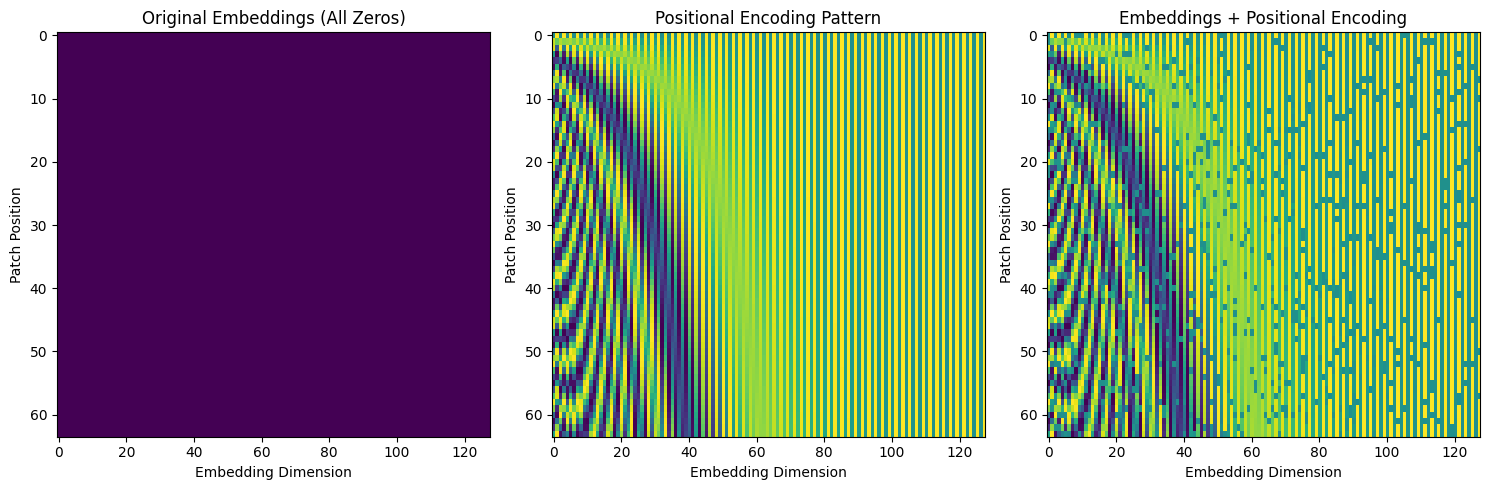

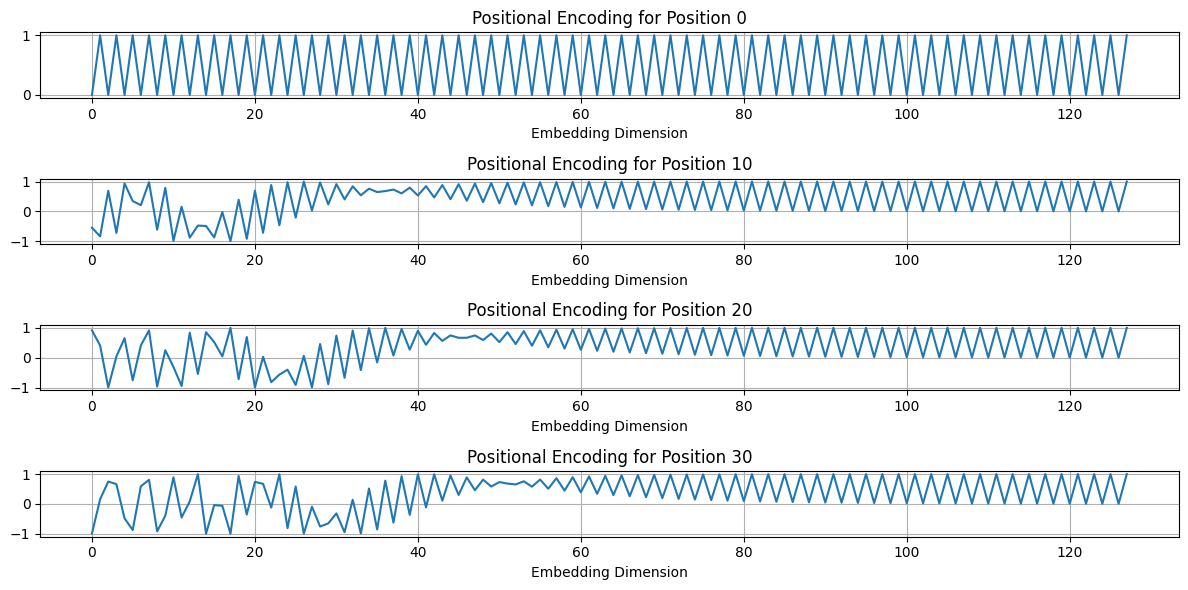

Positional encoding shape: torch.Size([1, 64, 128])
Positional encoding test completed!


In [12]:
def test_positional_encoding():
    """
    Test function to demonstrate and visualize the positional encoding.
    
    This function:
    1. Creates sample patch embeddings
    2. Applies positional encoding
    3. Visualizes the encoding patterns
    """
    # Create a batch of 1 with 64 patches, each with 128-dimensional embeddings
    # We use zeros to better visualize the effect of only the positional encoding
    batch_size = 1
    num_patches = 64  # For example, from a 4x4x4 volume with 1x1x1 patches
    embed_dim = 128
    
    # Create zero embeddings (to focus on positional encoding effect)
    embeddings = torch.zeros(batch_size, num_patches, embed_dim)
    
    # Initialize positional encoding
    pos_encoder = PositionalEncoding3D(embed_dim=embed_dim, max_len=num_patches)
    
    # Apply positional encoding
    encoded_embeddings = pos_encoder(embeddings)
    
    # Now let's visualize the positional encoding patterns
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Original embeddings (all zeros)
    plt.subplot(1, 3, 1)
    plt.imshow(embeddings[0].detach().numpy(), aspect='auto', cmap='viridis')
    plt.title("Original Embeddings (All Zeros)")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Patch Position")
    
    # Plot 2: Positional encoding only
    plt.subplot(1, 3, 2)
    plt.imshow(pos_encoder.pe[0, :num_patches, :].detach().numpy(), aspect='auto', cmap='viridis')
    plt.title("Positional Encoding Pattern")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Patch Position")
    
    # Plot 3: Embeddings with positional encoding added
    plt.subplot(1, 3, 3)
    plt.imshow(encoded_embeddings[0].detach().numpy(), aspect='auto', cmap='viridis')
    plt.title("Embeddings + Positional Encoding")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Patch Position")
    
    plt.tight_layout()
    plt.show()
    
    # Plot the encoding for specific positions to see the patterns
    plt.figure(figsize=(12, 6))
    
    # Select specific positions to visualize
    positions_to_plot = [0, 10, 20, 30]
    
    for i, pos in enumerate(positions_to_plot):
        plt.subplot(len(positions_to_plot), 1, i+1)
        plt.plot(pos_encoder.pe[0, pos, :].detach().numpy())
        plt.title(f"Positional Encoding for Position {pos}")
        plt.xlabel("Embedding Dimension")
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Positional encoding shape:", encoded_embeddings.shape)
    print("Positional encoding test completed!")

# Run the test
test_positional_encoding()

## Image 1 (Heatmap Visualization):
This shows three heatmaps displaying how positional encoding is applied to embeddings:

*Left*: The original embeddings (all zeros, shown as dark purple), which have no positional information
*Middle*: The positional encoding pattern, showing distinct yellow and blue patterns that vary across positions (y-axis) and embedding dimensions (x-axis)
*Right*: The result of adding positional encoding to the embeddings, which maintains the same pattern as the middle image since the original embeddings were zeros

The key insight is that each position (0-64) gets a unique encoding pattern across all embedding dimensions (0-128), allowing the transformer to distinguish between patches based on their position.

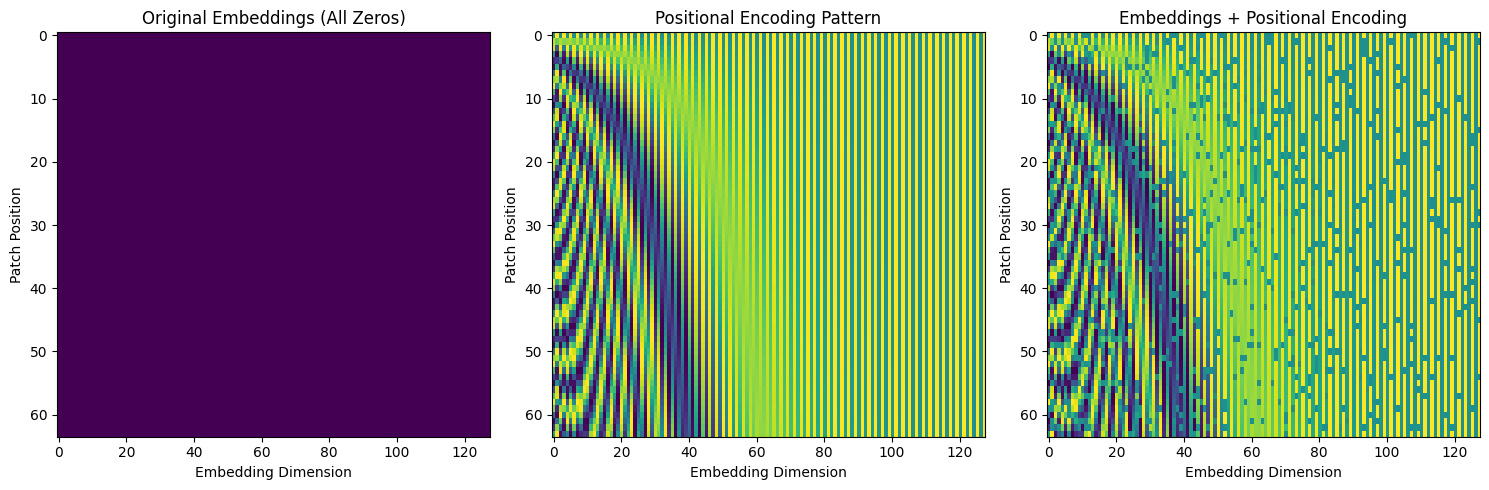


## Image 2 (Line Plots):
This shows the specific encoding patterns for four different positions (0, 10, 20, 30):

Position 0: Regular high-frequency sine/cosine pattern across all dimensions
Positions 10, 20, 30: Each has a unique pattern, especially visible in the lower dimensions (0-40)
All positions show similar high-frequency patterns in higher dimensions (40-128)

These unique "fingerprints" for each position allow the transformer to learn spatial relationships between patches despite processing them in parallel. The varying frequencies across dimensions help the model distinguish both nearby and distant positions.

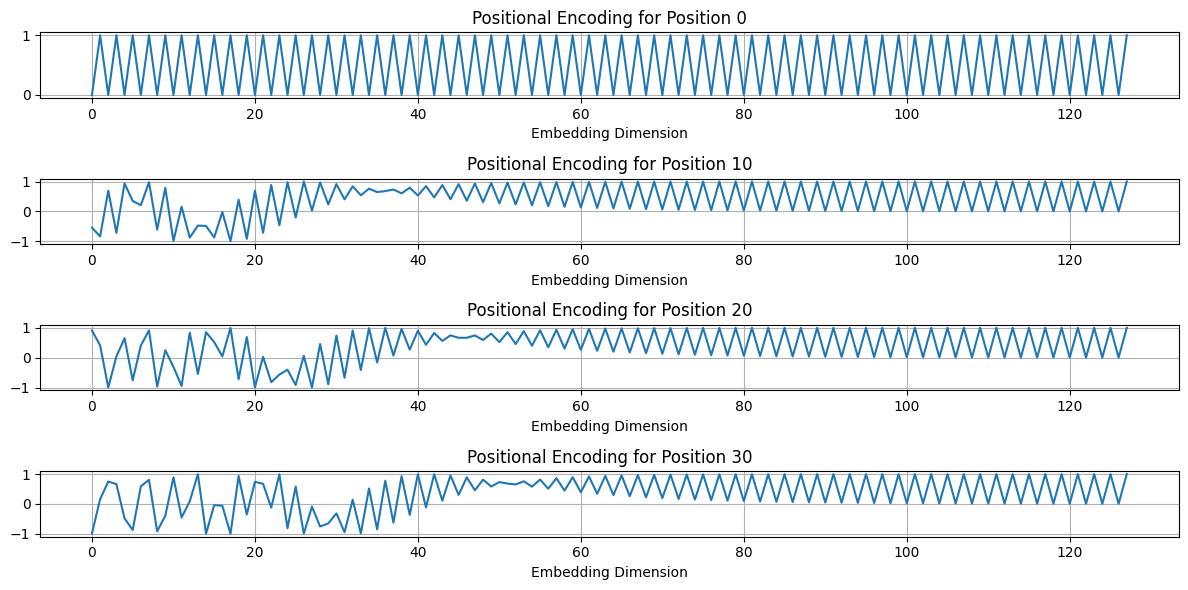

## Part 3: Multi-Head Attention Mechanism

Now that we have patch embeddings with positional information, let's implement the core component of transformers: the self-attention mechanism. Specifically, we'll implement the Multi-Head Attention (MHA) module that allows the model to attend to different parts of the input in parallel.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism for processing 3D microscopy data.
    
    This allows the model to jointly attend to information from different representation
    subspaces at different positions, enabling it to capture various types of relationships
    between patches.
    """
    def __init__(self, embed_dim, num_heads):
        """
        Initialize the multi-head attention module.
        
        Args:
            embed_dim (int): Dimension of input embeddings
            num_heads (int): Number of attention heads
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        # Calculate dimension per head, ensuring it divides evenly
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Linear projections for query, key, value computation
        # Combined into one layer to improve efficiency
        # Output has 3x the dimension to contain Q, K, V
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        
        # Output projection
        self.proj = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        """
        Forward pass of multi-head attention.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_patches, embed_dim]
            
        Returns:
            torch.Tensor: Output after attention of shape [batch_size, num_patches, embed_dim]
        """
        # Get batch size, sequence length, and embedding dimension
        B, N, C = x.shape
        
        # Generate query, key, value projections - all at once for efficiency
        # qkv shape: [B, N, 3, num_heads, head_dim]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        
        # Permute to separate Q, K, V and put heads dimension before sequence
        # shape: [3, B, num_heads, N, head_dim]
        qkv = qkv.permute(2, 0, 3, 1, 4)
        
        # Unpack query, key, value
        # Each has shape: [B, num_heads, N, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores
        # Matmul of q and k (transposed)
        # shape: [B, num_heads, N, N]
        attn = (q @ k.transpose(-2, -1))
        
        # Scale attention scores by square root of head dimension
        # This prevents softmax from having extremely small gradients
        attn = attn * (self.head_dim ** -0.5)
        
        # Apply softmax to get attention weights
        # Softmax ensures weights sum to 1 across the last dimension (key sequence)
        attn = F.softmax(attn, dim=-1)
        
        # Apply attention weights to values
        # shape: [B, num_heads, N, head_dim]
        x = attn @ v
        
        # Reshape and permute to combine heads and project back to original dimension
        # shape: [B, N, embed_dim]
        x = x.transpose(1, 2).reshape(B, N, C)
        
        # Final projection
        x = self.proj(x)
        
        return x

Input shape: torch.Size([1, 64, 128])
Output shape: torch.Size([1, 64, 128])
Multi-head attention test passed!


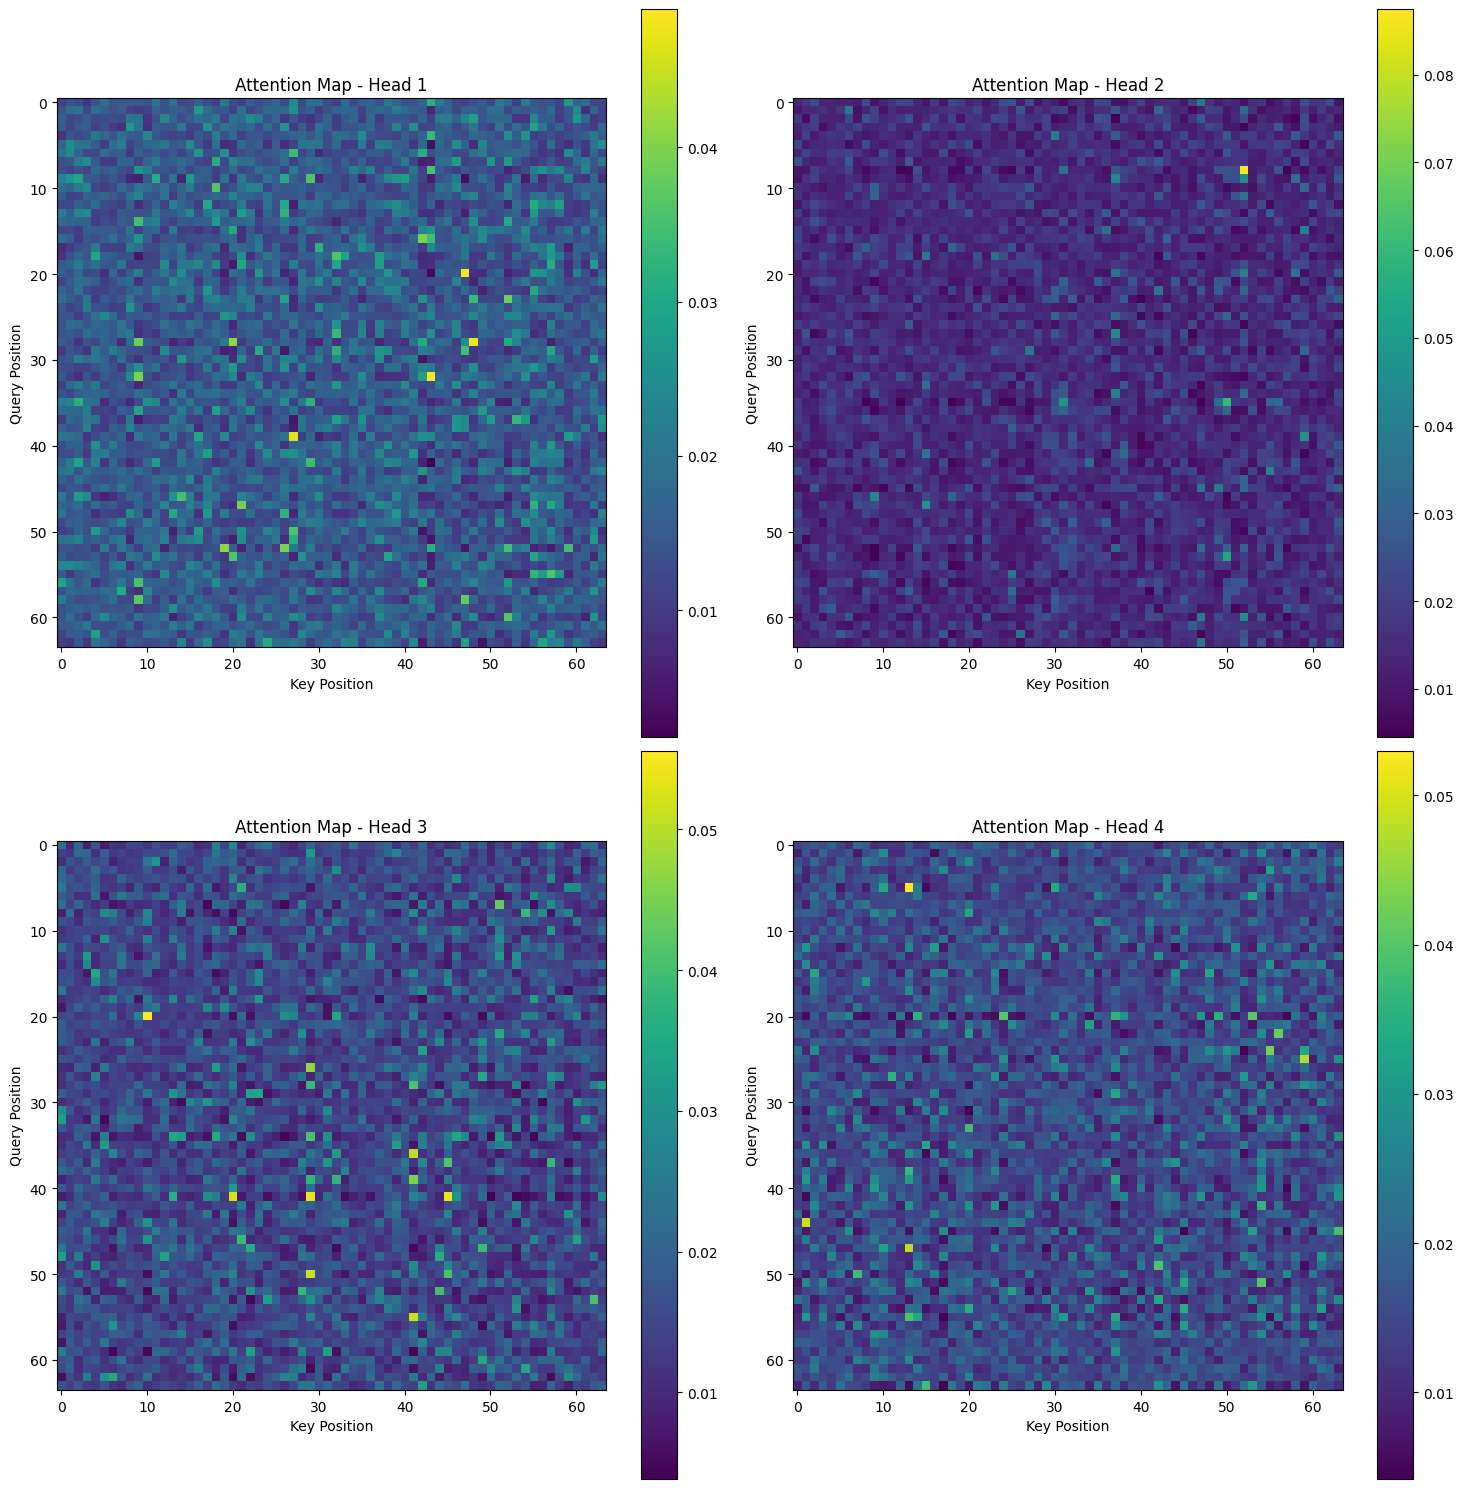

In [14]:
def test_multi_head_attention():
    """
    Test function to demonstrate the multi-head attention mechanism.
    
    This function:
    1. Creates sample patch embeddings with positional encoding
    2. Applies multi-head attention
    3. Visualizes attention patterns
    """
    # Parameters
    batch_size = 1
    num_patches = 64
    embed_dim = 128
    num_heads = 8
    
    # Create random embeddings to simulate patch embeddings with positional info
    # Using random init here instead of zeros to simulate real embeddings
    embeddings = torch.randn(batch_size, num_patches, embed_dim)
    
    # Initialize multi-head attention
    mha = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads)
    
    # Apply multi-head attention
    output = mha(embeddings)
    
    # Print output shape
    print(f"Input shape: {embeddings.shape}")
    print(f"Output shape: {output.shape}")
    print("Multi-head attention test passed!")
    
    # Let's visualize the attention pattern for one head
    # We need to run the model again to capture the attention weights
    with torch.no_grad():  # No need to track gradients for visualization
        # Get batch size, sequence length, and embedding dimension
        B, N, C = embeddings.shape
        
        # Generate query, key, value projections
        qkv = mha.qkv(embeddings).reshape(B, N, 3, mha.num_heads, mha.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores for first head
        attn = (q @ k.transpose(-2, -1)) * (mha.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        
        # Visualize attention maps for each head
        plt.figure(figsize=(15, 15))
        
        # We'll visualize attention maps for the first 4 heads
        heads_to_plot = min(4, num_heads)
        
        for i in range(heads_to_plot):
            plt.subplot(2, 2, i+1)
            plt.imshow(attn[0, i].detach().numpy(), cmap='viridis')
            plt.title(f"Attention Map - Head {i+1}")
            plt.xlabel("Key Position")
            plt.ylabel("Query Position")
            plt.colorbar()
        
        plt.tight_layout()
        plt.show()

# Run the test
test_multi_head_attention()

#### Key Concepts to Understand About Multi-Head Attention:

1. **Self-Attention Mechanism**: The attention mechanism allows each patch to attend to all other patches, learning which parts of the input are most relevant for each position.
Query, Key, Value (QKV) Projections:

2. **Query (Q)**: Represents what the model is "looking for" at each position
**Key (K)**: Represents what each position "contains" or "offers"
**Value (V)**: Represents the actual content to be aggregated


3. **Multi-Head Concept**: Multiple attention "heads" allow the model to focus on different aspects of the relationships between patches in parallel.
4. **Attention Scores**: Computed as the dot product between query and key vectors, measuring compatibility or relevance.
5. **Scaling Factor**: Dividing by √(head_dim) prevents extremely small gradients when using softmax on large values.
6. **Softmax Application**: Ensures attention weights sum to 1, creating a proper probability distribution over the input.
7. **Linear Projections**: Used to transform embeddings into query/key/value (QKV) space and then back to the original embedding space.

#### Visualizing Attention Patterns:
The visualization will show attention maps for each head, revealing how different heads focus on different relationships between patches. In the context of 3D microscopy:

Some heads might focus on local structures within a slice
Others might focus on connecting corresponding structures across slices
Some may attend to global patterns across the entire volume

This multi-faceted attention mechanism is key to the transformer's ability to fuse information from different parts of the 3D microscopy data.

In [15]:
import torch
import torch.nn as nn

class TransformerBlock(nn.Module):
    """
    Complete transformer block for 3D vision transformer.
    
    This combines multi-head self-attention with feed-forward networks,
    layer normalization, and residual connections to form the basic
    building block of the transformer architecture.
    """
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        """
        Initialize the transformer block.
        
        Args:
            embed_dim (int): Dimension of input embeddings
            num_heads (int): Number of attention heads
            mlp_ratio (float): Multiplier for the hidden dimension in the MLP
            dropout (float): Dropout probability
        """
        super().__init__()
        
        # Layer normalization before attention (helps training stability)
        self.norm1 = nn.LayerNorm(embed_dim)
        
        # Multi-head attention layer
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        
        # Layer normalization before MLP
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Multi-layer perceptron (MLP) block
        # The hidden dimension is embed_dim * mlp_ratio
        self.mlp = nn.Sequential(
            # First fully connected layer expands to larger dimension
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            # GELU activation (smoother than ReLU, often used in transformers)
            nn.GELU(),
            # Dropout for regularization
            nn.Dropout(dropout),
            # Second fully connected layer reduces back to embed_dim
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            # Final dropout
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        """
        Forward pass of the transformer block.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_patches, embed_dim]
            
        Returns:
            torch.Tensor: Output tensor of shape [batch_size, num_patches, embed_dim]
        """
        # Apply self-attention with residual connection and layer normalization
        # The residual connection (x + ...) helps with gradient flow
        # Pre-norm architecture: normalize before the operation
        x = x + self.attn(self.norm1(x))
        
        # Apply MLP with residual connection and layer normalization
        x = x + self.mlp(self.norm2(x))
        
        return x

Input shape: torch.Size([2, 64, 128])
Output shape: torch.Size([2, 64, 128])
Transformer block test passed!


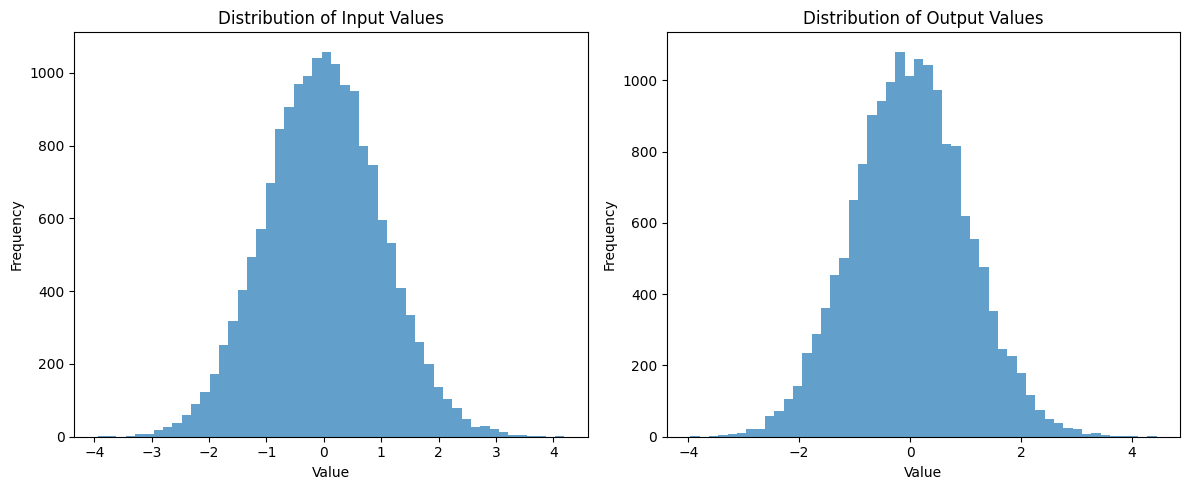

In [16]:
def test_transformer_block():
    """
    Test function to demonstrate the transformer block.
    
    This function:
    1. Creates sample patch embeddings
    2. Applies the transformer block
    3. Verifies input and output shapes
    """
    # Parameters
    batch_size = 2
    num_patches = 64
    embed_dim = 128
    num_heads = 8
    
    # Create random embeddings
    embeddings = torch.randn(batch_size, num_patches, embed_dim)
    
    # Initialize transformer block
    transformer = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads)
    
    # Apply transformer block
    output = transformer(embeddings)
    
    # Print shapes and verify
    print(f"Input shape: {embeddings.shape}")
    print(f"Output shape: {output.shape}")
    
    # Verify shapes match (transformer preserves dimensions)
    assert embeddings.shape == output.shape, "Input and output shapes should match!"
    
    print("Transformer block test passed!")
    
    # Let's examine how the data changes through the transformer block
    # We'll visualize the distribution of values before and after
    plt.figure(figsize=(12, 5))
    
    # Plot distribution of input values
    plt.subplot(1, 2, 1)
    plt.hist(embeddings.detach().numpy().flatten(), bins=50, alpha=0.7)
    plt.title("Distribution of Input Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    
    # Plot distribution of output values
    plt.subplot(1, 2, 2)
    plt.hist(output.detach().numpy().flatten(), bins=50, alpha=0.7)
    plt.title("Distribution of Output Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Run the test
test_transformer_block()

In [17]:
import torch
import torch.nn as nn

class ViT3D(nn.Module):
    """
    Complete 3D Vision Transformer for microscopy image fusion.
    
    This model:
    1. Embeds 3D patches from microscopy volumes
    2. Adds positional encoding
    3. Processes patches through transformer blocks
    4. Incorporates study-specific metadata
    5. Reconstructs the fused output volume
    """
    def __init__(self, vol_size=(64, 64, 64), patch_size=(8, 8, 8), 
                 in_channels=1, out_channels=1, embed_dim=128, depth=6, 
                 num_heads=8, mlp_ratio=4.0, dropout=0.1):
        """
        Initialize the 3D Vision Transformer.
        
        Args:
            vol_size (tuple): Size of input volume (D, H, W)
            patch_size (tuple): Size of each patch (D, H, W)
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels
            embed_dim (int): Dimension of patch embeddings
            depth (int): Number of transformer blocks
            num_heads (int): Number of attention heads
            mlp_ratio (float): Ratio for MLP hidden dim
            dropout (float): Dropout probability
        """
        super().__init__()
        
        # Store key parameters
        self.vol_size = vol_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Study-specific metadata embedding
        # For encoding study ID (categorical) and voxel size (continuous)
        self.study_embed = nn.Embedding(10, embed_dim)  # 10 possible studies
        self.voxel_size_embed = nn.Linear(3, embed_dim)  # 3D voxel size
        
        # Patch embedding layer
        self.patch_embed = PatchEmbed3D(vol_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Class token - special token added to the sequence
        # Used for global representation of the volume
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Positional embedding layer
        self.pos_embed = PositionalEncoding3D(embed_dim, dropout, max_len=num_patches + 1)  # +1 for cls token
        
        # Transformer blocks - the core of the model
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)
        
        # Reconstruction head to convert embeddings back to 3D volume
        self.reconstruct_head = nn.Sequential(
            nn.Linear(embed_dim, patch_size[0] * patch_size[1] * patch_size[2] * out_channels),
            nn.Unflatten(2, (patch_size[0], patch_size[1], patch_size[2], out_channels))
        )
        
    def forward(self, x, study_id, voxel_size):
        """
        Forward pass of the 3D Vision Transformer.
        
        Args:
            x (torch.Tensor): Input volume of shape [B, C, D, H, W]
            study_id (torch.Tensor): Study ID of shape [B]
            voxel_size (torch.Tensor): Voxel dimensions of shape [B, 3]
            
        Returns:
            torch.Tensor: Reconstructed output volume of shape [B, C, D, H, W]
        """
        # Get batch size
        B = x.shape[0]
        
        # Apply patch embedding
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        
        # Add metadata embeddings
        # Convert study ID to embedding
        study_emb = self.study_embed(study_id).unsqueeze(1)  # [B, 1, embed_dim]
        # Convert voxel size to embedding
        voxel_emb = self.voxel_size_embed(voxel_size).unsqueeze(1)  # [B, 1, embed_dim]
        
        # Add CLS token to sequence
        cls_token = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_token, x), dim=1)  # [B, 1 + num_patches, embed_dim]
        
        # Add positional encoding
        x = self.pos_embed(x)
        
        # Add study and voxel size embeddings to CLS token
        # This injects metadata information into the global representation
        x[:, 0, :] += study_emb.squeeze(1)
        x[:, 0, :] += voxel_emb.squeeze(1)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply final normalization
        x = self.norm(x)
        
        # Separate CLS token and patch tokens
        cls_token_final = x[:, 0]  # [B, embed_dim]
        x = x[:, 1:]  # [B, num_patches, embed_dim]
        
        # Reconstruct volume from embeddings
        # First, apply a linear projection to get patch contents
        batch_size, num_patches, _ = x.shape
        
        # Project each patch embedding to patch_size x out_channels
        x = self.reconstruct_head(x)  # [B, num_patches, D', H', W', C_out]
        
        # Rearrange to final volume shape
        D, H, W = self.vol_size
        D_p, H_p, W_p = self.patch_size
        
        # Calculate grid dimensions
        D_grid, H_grid, W_grid = D // D_p, H // H_p, W // W_p
        
        # Reshape to [B, D_grid, H_grid, W_grid, D_p, H_p, W_p, C_out]
        x = x.view(batch_size, D_grid, H_grid, W_grid, D_p, H_p, W_p, -1)
        
        # Permute and reshape to final volume format [B, C_out, D, H, W]
        x = x.permute(0, 7, 1, 4, 2, 5, 3, 6).contiguous()
        x = x.view(batch_size, -1, D, H, W)
        
        return x

Input volume shape: torch.Size([2, 1, 64, 64, 64])
Output volume shape: torch.Size([2, 1, 64, 64, 64])
3D Vision Transformer test passed!


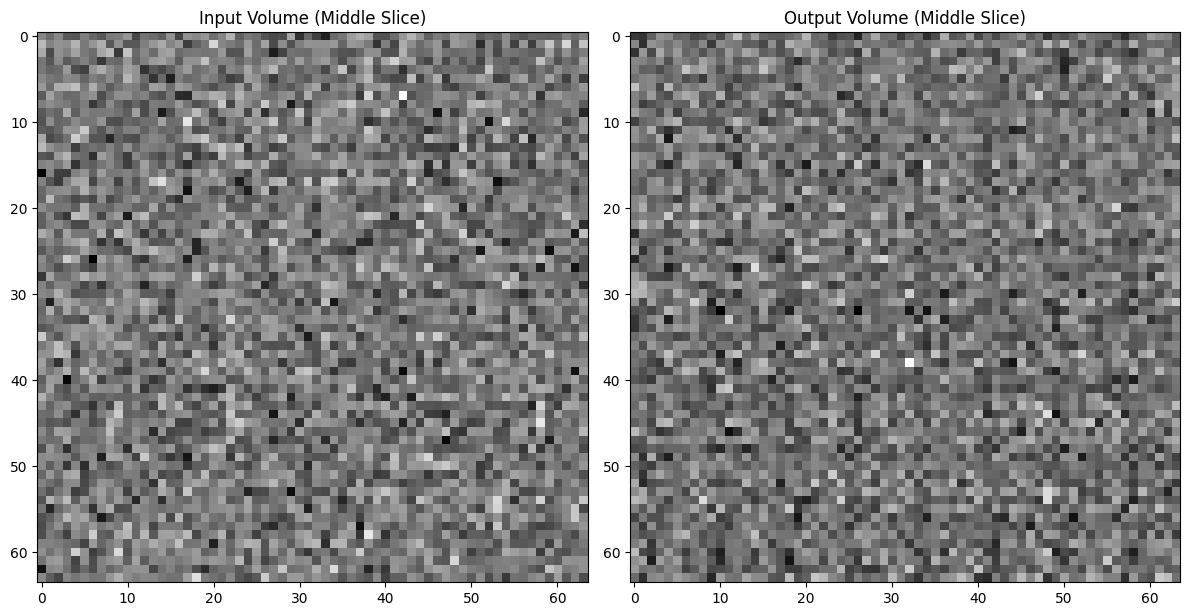

Total number of parameters: 530,432

Parameter counts by component:
Patch Embedding: 65,664
Study Embedding: 1,280
Voxel Size Embedding: 512
Transformer Blocks: 396,544
Reconstruction Head: 66,048


In [18]:
def test_vit3d():
    """
    Test function to demonstrate the complete 3D Vision Transformer.
    
    This function:
    1. Creates a random input volume
    2. Creates example study metadata
    3. Applies the 3D ViT model
    4. Verifies input and output shapes
    """
    # Parameters
    batch_size = 2
    in_channels = 1
    out_channels = 1
    vol_size = (64, 64, 64)
    patch_size = (8, 8, 8)
    embed_dim = 128
    
    # Create random input volume
    input_vol = torch.randn(batch_size, in_channels, *vol_size)
    
    # Create example study metadata
    study_ids = torch.tensor([0, 1], dtype=torch.long)  # Two different studies
    voxel_sizes = torch.tensor([
        [0.195, 0.195, 1.0],  # Study 0: typical resolution for Study 1
        [0.333, 0.333, 3.0]   # Study 1: typical resolution for Study 4
    ], dtype=torch.float)
    
    # Initialize the 3D ViT model
    model = ViT3D(
        vol_size=vol_size,
        patch_size=patch_size,
        in_channels=in_channels,
        out_channels=out_channels,
        embed_dim=embed_dim,
        depth=2,  # Using only 2 transformer blocks for testing
        num_heads=8
    )
    
    # Apply the model
    output_vol = model(input_vol, study_ids, voxel_sizes)
    
    # Print shapes
    print(f"Input volume shape: {input_vol.shape}")
    print(f"Output volume shape: {output_vol.shape}")
    
    # Verify shapes match
    assert input_vol.shape == output_vol.shape, "Input and output shapes should match!"
    
    print("3D Vision Transformer test passed!")
    
    # Visualize a slice from input and output for comparison
    plt.figure(figsize=(12, 6))
    
    # Plot a slice from the first volume in the batch
    plt.subplot(1, 2, 1)
    plt.imshow(input_vol[0, 0, 32, :, :].detach().numpy(), cmap='gray')
    plt.title("Input Volume (Middle Slice)")
    
    # Plot the corresponding slice from the output
    plt.subplot(1, 2, 2)
    plt.imshow(output_vol[0, 0, 32, :, :].detach().numpy(), cmap='gray')
    plt.title("Output Volume (Middle Slice)")
    
    plt.tight_layout()
    plt.show()
    
    # Print model summary (parameter count)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,}")
    
    # Print parameter counts for each major component
    print("\nParameter counts by component:")
    print(f"Patch Embedding: {sum(p.numel() for p in model.patch_embed.parameters()):,}")
    print(f"Study Embedding: {sum(p.numel() for p in model.study_embed.parameters()):,}")
    print(f"Voxel Size Embedding: {sum(p.numel() for p in model.voxel_size_embed.parameters()):,}")
    print(f"Transformer Blocks: {sum(p.numel() for p in model.blocks.parameters()):,}")
    print(f"Reconstruction Head: {sum(p.numel() for p in model.reconstruct_head.parameters()):,}")

# Run the test
test_vit3d()

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MicroscopyFusionLoss(nn.Module):
    """
    Custom loss function for microscopy fusion, combining structural, 
    gradient, and intensity-based losses.
    
    This loss function is designed to preserve:
    1. Overall image intensity (via BCE or MSE)
    2. Structural information (via SSIM)
    3. Edge and gradient information (via gradient consistency)
    """
    def __init__(self, alpha=1.0, beta=0.5, gamma=0.2):
        """
        Initialize the microscopy fusion loss.
        
        Args:
            alpha (float): Weight for intensity loss (BCE/MSE)
            beta (float): Weight for structural loss (SSIM)
            gamma (float): Weight for gradient loss
        """
        super().__init__()
        self.alpha = alpha  # Weight for intensity loss
        self.beta = beta    # Weight for SSIM loss
        self.gamma = gamma  # Weight for gradient loss
        
    def forward(self, pred, target):
        """
        Calculate the combined loss.
        
        Args:
            pred (torch.Tensor): Predicted volume [B, C, D, H, W]
            target (torch.Tensor): Target volume [B, C, D, H, W]
            
        Returns:
            torch.Tensor: Scalar loss value
        """
        # Intensity loss - Binary Cross Entropy or Mean Squared Error
        # For microscopy, MSE often works better when data is normalized to [0,1]
        intensity_loss = F.mse_loss(pred, target)
        
        # SSIM loss (computed slice by slice for 3D volumes)
        ssim_loss = 0.0
        batch_size = pred.shape[0]
        depth = pred.shape[2]
        
        # Iterate through each z-slice
        for z in range(depth):
            pred_slice = pred[:, :, z, :, :]  # [B, C, H, W]
            target_slice = target[:, :, z, :, :]
            
            # Calculate SSIM for this slice
            ssim_val = self.ssim(pred_slice, target_slice)
            
            # Convert SSIM to a loss (1 - SSIM)
            ssim_loss += (1.0 - ssim_val)
        
        # Average SSIM loss over all slices
        ssim_loss /= depth
        
        # Gradient consistency loss
        grad_loss = self.gradient_loss(pred, target)
        
        # Combine all losses with their respective weights
        total_loss = (
            self.alpha * intensity_loss + 
            self.beta * ssim_loss + 
            self.gamma * grad_loss
        )
        
        return total_loss, {
            'intensity_loss': intensity_loss.item(),
            'ssim_loss': ssim_loss.item(),
            'gradient_loss': grad_loss.item(),
            'total_loss': total_loss.item()
        }
    
    def ssim(self, x, y, win_size=11, data_range=1.0, k1=0.01, k2=0.03):
        """
        Calculate SSIM (Structural Similarity Index) for 2D images.
        
        Args:
            x, y (torch.Tensor): Input images [B, C, H, W]
            win_size (int): Size of the Gaussian window
            data_range (float): Range of the input data (typically 1.0 for normalized images)
            k1, k2 (float): SSIM stability constants
            
        Returns:
            torch.Tensor: Mean SSIM value
        """
        # Constants for stability
        C1 = (k1 * data_range) ** 2
        C2 = (k2 * data_range) ** 2
        
        # Create Gaussian window
        window = self._create_window(win_size).to(x.device)
        
        # Expand window to match input channels
        window = window.expand(x.shape[1], 1, win_size, win_size)
        
        # Calculate means
        mu1 = F.conv2d(x, window, padding=win_size//2, groups=x.shape[1])
        mu2 = F.conv2d(y, window, padding=win_size//2, groups=y.shape[1])
        
        # Calculate squared means
        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2
        
        # Calculate variances and covariance
        sigma1_sq = F.conv2d(x * x, window, padding=win_size//2, groups=x.shape[1]) - mu1_sq
        sigma2_sq = F.conv2d(y * y, window, padding=win_size//2, groups=y.shape[1]) - mu2_sq
        sigma12 = F.conv2d(x * y, window, padding=win_size//2, groups=x.shape[1]) - mu1_mu2
        
        # Calculate SSIM
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        
        # Return mean SSIM
        return ssim_map.mean()
    
    def _create_window(self, win_size):
        """
        Create a Gaussian window for SSIM calculation.
        
        Args:
            win_size (int): Size of the window
            
        Returns:
            torch.Tensor: Gaussian window
        """
        import math
        
        # Create 1D Gaussian kernel
        sigma = 1.5
        gauss = torch.Tensor([math.exp(-(x - win_size//2)**2/float(2*sigma**2)) 
                             for x in range(win_size)])
        
        # Normalize
        gauss = gauss / gauss.sum()
        
        # Create 2D Gaussian kernel
        _1D_window = gauss.unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t())
        
        # Reshape to [1, 1, win_size, win_size] for conv2d
        window = _2D_window.unsqueeze(0).unsqueeze(0)
        
        return window
    
    def gradient_loss(self, pred, target):
        """
        Calculate gradient consistency loss in all three dimensions.
        
        This focuses on preserving edges and boundaries in the volume.
        
        Args:
            pred (torch.Tensor): Predicted volume [B, C, D, H, W]
            target (torch.Tensor): Target volume [B, C, D, H, W]
            
        Returns:
            torch.Tensor: Gradient consistency loss
        """
        # Helper function to compute gradients
        def compute_gradient(volume):
            # Gradient in X direction (width)
            dx = volume[:, :, :, :, 1:] - volume[:, :, :, :, :-1]
            
            # Gradient in Y direction (height)
            dy = volume[:, :, :, 1:, :] - volume[:, :, :, :-1, :]
            
            # Gradient in Z direction (depth)
            dz = volume[:, :, 1:, :, :] - volume[:, :, :-1, :, :]
            
            return dx, dy, dz
        
        # Compute gradients for prediction and target
        pred_dx, pred_dy, pred_dz = compute_gradient(pred)
        target_dx, target_dy, target_dz = compute_gradient(target)
        
        # Calculate MSE between gradients
        loss_dx = F.mse_loss(pred_dx, target_dx)
        loss_dy = F.mse_loss(pred_dy, target_dy)
        loss_dz = F.mse_loss(pred_dz, target_dz)
        
        # Weight Z direction differently due to potential anisotropy
        # In microscopy, Z resolution is often lower than XY
        z_weight = 0.5  # Lower weight for Z gradients
        
        # Combine losses
        grad_loss = (loss_dx + loss_dy + loss_dz * z_weight) / (2 + z_weight)
        
        return grad_loss

Loss components for noise perturbation:
  intensity_loss: 0.0201
  ssim_loss: 0.9565
  gradient_loss: 0.0276
  total_loss: 0.5038

Loss components for blur perturbation:
  intensity_loss: 0.0035
  ssim_loss: 0.0770
  gradient_loss: 0.0054
  total_loss: 0.0431

Loss components for shift perturbation:
  intensity_loss: 0.0252
  ssim_loss: 0.0962
  gradient_loss: 0.0126
  total_loss: 0.0758


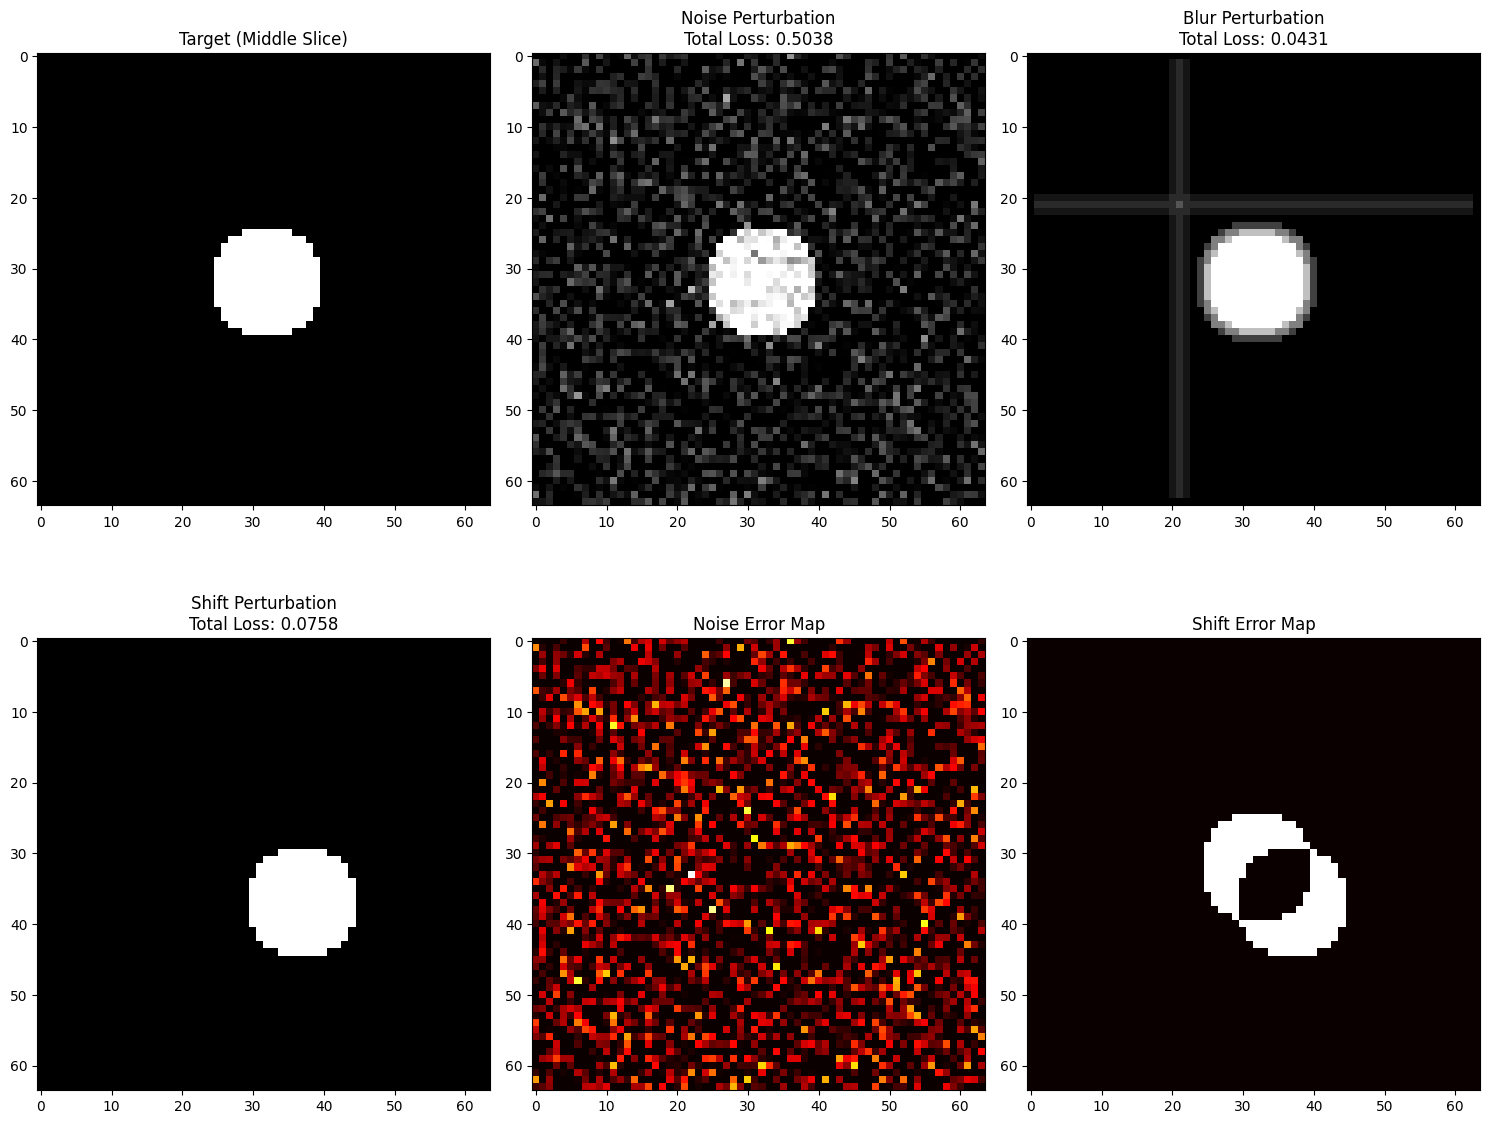

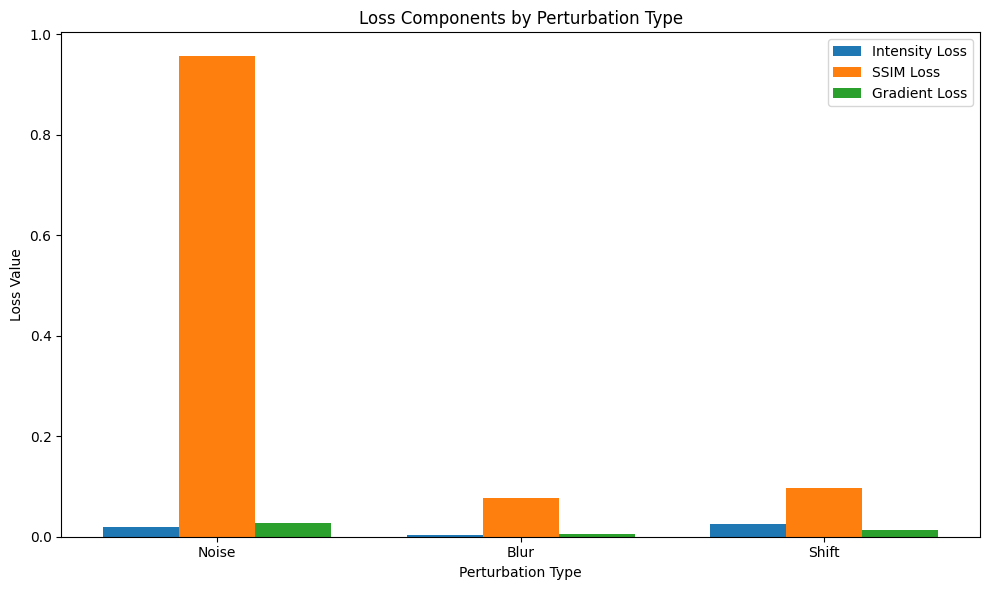

In [20]:
def test_microscopy_fusion_loss():
    """
    Test function to demonstrate the microscopy fusion loss.
    
    This function:
    1. Creates synthetic 3D volumes with known structures
    2. Calculates the loss components
    3. Visualizes how the loss responds to different perturbations
    """
    # Create a synthetic target with some structures
    # For example, a 3D volume with a sphere and some lines
    vol_size = (32, 64, 64)  # Smaller for demonstration
    target = torch.zeros(1, 1, *vol_size)
    
    # Create a sphere in the center
    center = (vol_size[0]//2, vol_size[1]//2, vol_size[2]//2)
    radius = min(vol_size) // 4
    
    for z in range(vol_size[0]):
        for y in range(vol_size[1]):
            for x in range(vol_size[2]):
                # Distance from center
                dist = ((z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2)**0.5
                # Inside sphere
                if dist < radius:
                    target[0, 0, z, y, x] = 1.0
    
    # Add some lines for edge structure
    for z in range(5, vol_size[0]-5, 10):
        target[0, 0, z, :, vol_size[2]//3] = 1.0
        target[0, 0, z, vol_size[1]//3, :] = 1.0
    
    # Create predictions with different types of perturbations
    
    # 1. Noise perturbation (affects intensity)
    noise_level = 0.2
    pred_noise = target + torch.randn_like(target) * noise_level
    pred_noise = torch.clamp(pred_noise, 0, 1)
    
    # 2. Blur perturbation (affects structure/edges)
    pred_blur = target.clone()
    for z in range(1, vol_size[0]-1):
        # Simple 3x3 average blur
        pred_blur[0, 0, z, 1:-1, 1:-1] = (
            target[0, 0, z-1:z+2, 0:-2, 1:-1].mean(dim=0) +
            target[0, 0, z-1:z+2, 1:-1, 0:-2].mean(dim=0) +
            target[0, 0, z-1:z+2, 2:, 1:-1].mean(dim=0) +
            target[0, 0, z-1:z+2, 1:-1, 2:].mean(dim=0)
        ) / 4.0
    
    # 3. Shift perturbation (affects gradients)
    pred_shift = torch.zeros_like(target)
    pred_shift[0, 0, :, 5:, 5:] = target[0, 0, :, :-5, :-5]
    
    # Initialize the loss function
    loss_fn = MicroscopyFusionLoss(alpha=1.0, beta=0.5, gamma=0.2)
    
    # Calculate losses for each perturbation
    loss_noise, components_noise = loss_fn(pred_noise, target)
    loss_blur, components_blur = loss_fn(pred_blur, target)
    loss_shift, components_shift = loss_fn(pred_shift, target)
    
    # Print the loss components
    print("Loss components for noise perturbation:")
    for k, v in components_noise.items():
        print(f"  {k}: {v:.4f}")
    
    print("\nLoss components for blur perturbation:")
    for k, v in components_blur.items():
        print(f"  {k}: {v:.4f}")
    
    print("\nLoss components for shift perturbation:")
    for k, v in components_shift.items():
        print(f"  {k}: {v:.4f}")
    
    # Visualize the different volumes and their perturbations
    plt.figure(figsize=(15, 12))
    
    # Show middle slices
    mid_z = vol_size[0] // 2
    
    # Original target
    plt.subplot(2, 3, 1)
    plt.imshow(target[0, 0, mid_z, :, :].detach().numpy(), cmap='gray')
    plt.title("Target (Middle Slice)")
    
    # Noise perturbation
    plt.subplot(2, 3, 2)
    plt.imshow(pred_noise[0, 0, mid_z, :, :].detach().numpy(), cmap='gray')
    plt.title(f"Noise Perturbation\nTotal Loss: {components_noise['total_loss']:.4f}")
    
    # Blur perturbation
    plt.subplot(2, 3, 3)
    plt.imshow(pred_blur[0, 0, mid_z, :, :].detach().numpy(), cmap='gray')
    plt.title(f"Blur Perturbation\nTotal Loss: {components_blur['total_loss']:.4f}")
    
    # Shift perturbation
    plt.subplot(2, 3, 4)
    plt.imshow(pred_shift[0, 0, mid_z, :, :].detach().numpy(), cmap='gray')
    plt.title(f"Shift Perturbation\nTotal Loss: {components_shift['total_loss']:.4f}")
    
    # Difference maps (to highlight errors)
    plt.subplot(2, 3, 5)
    plt.imshow(torch.abs(target - pred_noise)[0, 0, mid_z, :, :].detach().numpy(), cmap='hot')
    plt.title("Noise Error Map")
    
    plt.subplot(2, 3, 6)
    plt.imshow(torch.abs(target - pred_shift)[0, 0, mid_z, :, :].detach().numpy(), cmap='hot')
    plt.title("Shift Error Map")
    
    plt.tight_layout()
    plt.show()
    
    # Create a bar chart to compare loss components across perturbations
    perturbations = ['Noise', 'Blur', 'Shift']
    intensity_losses = [components_noise['intensity_loss'], 
                        components_blur['intensity_loss'], 
                        components_shift['intensity_loss']]
    ssim_losses = [components_noise['ssim_loss'], 
                   components_blur['ssim_loss'], 
                   components_shift['ssim_loss']]
    gradient_losses = [components_noise['gradient_loss'], 
                       components_blur['gradient_loss'], 
                       components_shift['gradient_loss']]
    
    x = np.arange(len(perturbations))
    width = 0.25
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width, intensity_losses, width, label='Intensity Loss')
    plt.bar(x, ssim_losses, width, label='SSIM Loss')
    plt.bar(x + width, gradient_losses, width, label='Gradient Loss')
    
    plt.xlabel('Perturbation Type')
    plt.ylabel('Loss Value')
    plt.title('Loss Components by Perturbation Type')
    plt.xticks(x, perturbations)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the test
test_microscopy_fusion_loss()

In [21]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def train_fusion_model(model, train_loader, val_loader, num_epochs=50, 
                      learning_rate=1e-4, device="cuda", 
                      save_path="./models/"):
    """
    Train the 3D Vision Transformer fusion model.
    
    Args:
        model (nn.Module): The ViT3D model
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
        num_epochs (int): Number of training epochs
        learning_rate (float): Learning rate for optimizer
        device (str): Device to train on ('cuda' or 'cpu')
        save_path (str): Directory to save model checkpoints
        
    Returns:
        model: Trained model
        history: Dictionary containing training and validation metrics
    """
    # Move model to device
    model = model.to(device)
    
    # Initialize optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = MicroscopyFusionLoss(alpha=1.0, beta=0.5, gamma=0.2)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Create directory for saving models if it doesn't exist
    import os
    os.makedirs(save_path, exist_ok=True)
    
    # Initialize training history
    history = {
        'train_loss': [],
        'train_intensity_loss': [],
        'train_ssim_loss': [],
        'train_gradient_loss': [],
        'val_loss': [],
        'val_intensity_loss': [],
        'val_ssim_loss': [],
        'val_gradient_loss': [],
        'learning_rates': []
    }
    
    # Best validation loss for model saving
    best_val_loss = float('inf')
    
    # Training loop
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_intensity_loss = 0.0
        train_ssim_loss = 0.0
        train_gradient_loss = 0.0
        
        # Create progress bar for training
        progress_bar = tqdm(train_loader, desc="Training")
        
        for batch_idx, (input_vol, study_id, voxel_size, target_vol) in enumerate(progress_bar):
            # Move batch to device
            input_vol = input_vol.to(device)
            study_id = study_id.to(device)
            voxel_size = voxel_size.to(device)
            target_vol = target_vol.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output_vol = model(input_vol, study_id, voxel_size)
            
            # Calculate loss
            loss, loss_components = criterion(output_vol, target_vol)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update running loss values
            train_loss += loss.item()
            train_intensity_loss += loss_components['intensity_loss']
            train_ssim_loss += loss_components['ssim_loss']
            train_gradient_loss += loss_components['gradient_loss']
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'int_loss': f"{loss_components['intensity_loss']:.4f}",
                'ssim_loss': f"{loss_components['ssim_loss']:.4f}",
                'grad_loss': f"{loss_components['gradient_loss']:.4f}"
            })
        
        # Calculate average training losses
        num_batches = len(train_loader)
        train_loss /= num_batches
        train_intensity_loss /= num_batches
        train_ssim_loss /= num_batches
        train_gradient_loss /= num_batches
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_intensity_loss = 0.0
        val_ssim_loss = 0.0
        val_gradient_loss = 0.0
        
        # Create progress bar for validation
        progress_bar = tqdm(val_loader, desc="Validation")
        
        with torch.no_grad():
            for batch_idx, (input_vol, study_id, voxel_size, target_vol) in enumerate(progress_bar):
                # Move batch to device
                input_vol = input_vol.to(device)
                study_id = study_id.to(device)
                voxel_size = voxel_size.to(device)
                target_vol = target_vol.to(device)
                
                # Forward pass
                output_vol = model(input_vol, study_id, voxel_size)
                
                # Calculate loss
                loss, loss_components = criterion(output_vol, target_vol)
                
                # Update running loss values
                val_loss += loss.item()
                val_intensity_loss += loss_components['intensity_loss']
                val_ssim_loss += loss_components['ssim_loss']
                val_gradient_loss += loss_components['gradient_loss']
                
                # Update progress bar
                progress_bar.set_postfix({
                    'val_loss': f"{loss.item():.4f}"
                })
        
        # Calculate average validation losses
        num_batches = len(val_loader)
        val_loss /= num_batches
        val_intensity_loss /= num_batches
        val_ssim_loss /= num_batches
        val_gradient_loss /= num_batches
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_intensity_loss'].append(train_intensity_loss)
        history['train_ssim_loss'].append(train_ssim_loss)
        history['train_gradient_loss'].append(train_gradient_loss)
        history['val_loss'].append(val_loss)
        history['val_intensity_loss'].append(val_intensity_loss)
        history['val_ssim_loss'].append(val_ssim_loss)
        history['val_gradient_loss'].append(val_gradient_loss)
        history['learning_rates'].append(current_lr)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f} - "
              f"Val Loss: {val_loss:.4f} - "
              f"LR: {current_lr:.6f}")
        
        # Save model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'history': history
            }, f"{save_path}/best_model.pth")
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'history': history
            }, f"{save_path}/checkpoint_epoch_{epoch+1}.pth")
            
        # Visualize a sample from the validation set
        if (epoch + 1) % 5 == 0:
            visualize_predictions(model, val_loader, device, epoch+1)
    
    # Calculate total training time
    total_time = time.time() - start_time
    hours = total_time // 3600
    minutes = (total_time % 3600) // 60
    seconds = total_time % 60
    
    print(f"Training completed in {int(hours)}h {int(minutes)}m {int(seconds)}s")
    
    # Plot training history
    plot_training_history(history)
    
    return model, history

def visualize_predictions(model, data_loader, device, epoch, num_samples=2):
    """
    Visualize model predictions on a few samples from the dataset.
    
    Args:
        model (nn.Module): The trained model
        data_loader (DataLoader): DataLoader containing the data
        device (str): Device for computation
        epoch (int): Current epoch number (for plot title)
        num_samples (int): Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of data
    input_vol, study_id, voxel_size, target_vol = next(iter(data_loader))
    
    # Only use the first num_samples
    input_vol = input_vol[:num_samples].to(device)
    study_id = study_id[:num_samples].to(device)
    voxel_size = voxel_size[:num_samples].to(device)
    target_vol = target_vol[:num_samples].to(device)
    
    # Generate predictions
    with torch.no_grad():
        output_vol = model(input_vol, study_id, voxel_size)
    
    # Plot results
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Get the middle slices
        input_slice = input_vol[i, 0, input_vol.shape[2]//2, :, :].cpu().numpy()
        target_slice = target_vol[i, 0, target_vol.shape[2]//2, :, :].cpu().numpy()
        output_slice = output_vol[i, 0, output_vol.shape[2]//2, :, :].cpu().numpy()
        
        # Plot input slice
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(input_slice, cmap='gray')
        plt.title(f"Input (Sample {i+1})")
        plt.axis('off')
        
        # Plot target slice
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(target_slice, cmap='gray')
        plt.title(f"Target (Sample {i+1})")
        plt.axis('off')
        
        # Plot output slice
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(output_slice, cmap='gray')
        plt.title(f"Prediction (Sample {i+1})")
        plt.axis('off')
    
    plt.suptitle(f"Epoch {epoch} - Model Predictions")
    plt.tight_layout()
    plt.savefig(f"./visualizations/epoch_{epoch}_predictions.png")
    plt.show()

def plot_training_history(history):
    """
    Plot the training and validation loss history.
    
    Args:
        history (dict): Dictionary containing training and validation metrics
    """
    # Create directory for visualizations if it doesn't exist
    import os
    os.makedirs("./visualizations", exist_ok=True)
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot training and validation loss
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot total loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss components
    ax2.plot(epochs, history['train_intensity_loss'], 'b--', label='Train Intensity Loss')
    ax2.plot(epochs, history['train_ssim_loss'], 'g--', label='Train SSIM Loss')
    ax2.plot(epochs, history['train_gradient_loss'], 'y--', label='Train Gradient Loss')
    ax2.plot(epochs, history['val_intensity_loss'], 'b-', label='Val Intensity Loss')
    ax2.plot(epochs, history['val_ssim_loss'], 'g-', label='Val SSIM Loss')
    ax2.plot(epochs, history['val_gradient_loss'], 'y-', label='Val Gradient Loss')
    ax2.set_title('Loss Components')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig("./visualizations/training_history.png")
    plt.show()
    
    # Plot learning rate
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history['learning_rates'])
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.savefig("./visualizations/learning_rate.png")
    plt.show()